### Imports

In [1]:
import sys
sys.path.append("..") # root of repo
import os
import numpy as np
import pandas as pd
import pickle as pkl
import ipywidgets as widgets
from collections import Counter, defaultdict
import os.path as osp
from pathlib import Path
from tqdm import tqdm
from PIL import Image
from src.data import MultiModalHblDataset
from src.utils import array2gif, draw_trajectory
import torchvision
import torch

from visualize_utils import * # debug import

### Convert dataset to Json

In [20]:
# f = plot_event_proportions("occurences_16_2_train.csv")
sql = 16
sr = 2
data_path = Path("/nfs/home/rhotertj/datasets/hbl")
dataset = MultiModalHblDataset(
    meta_path=data_path / "meta3d_train.csv",
    seq_len=sql,
    sampling_rate=sr,
    load_frames=False   
)
data_dict = []
for idx in tqdm(range(len(dataset))):
    instance = dataset[idx]
    label = instance["label"]
    data_dict.append(
        {
            "idx" : idx,
            "frame_idx" : instance["frame_idx"],
            "label" : label,
            "shot" : label.get("Wurf"),
            "pass" : label.get("Pass"),
            "outcome" : label.get("Ergebnis"),
            "body" : label.get("Körper"),
            "team" : label.get("Team"),
            "hand" : label.get("Hand"),
            "match_number" : instance["match_number"]
        }
    )



100%|██████████| 19823/19823 [00:13<00:00, 1515.07it/s]


In [21]:
df = pd.DataFrame(data_dict)

df = df.replace({np.nan:None})
# do stratified
df["class_fine"] = df.apply(generate_class_description_fine, axis=1)
df["class_coarse"] = df["class_fine"].apply(generate_class_description_coarse)
df.to_json(data_path / f"meta3d_train_{sql}_{sr}.jsonl", lines=True, orient="records")
df.sample(5)

,idx,frame_idx,label,shot,pass,outcome,body,team,hand,match_number,class_fine,class_coarse
3967,3967,23874,{},None,None,None,None,None,None,1,Background,Background
1683,1683,43245,{},None,None,None,None,None,None,0,Background,Background
8582,8582,36418,{},None,None,None,None,None,None,2,Background,Background
6997,6997,6378,{},None,None,None,None,None,None,2,Background,Background
6581,6581,78549,{},None,None,None,None,None,None,1,Background,Background


### Plot class occurences

In [16]:
df = pd.read_json("dataset_train_sql=16_sr=2_nooverlap.jsonl", lines=True)
df.sample(5)


,idx,frame_idx,label,shot,pass,outcome,body,team,hand,class_fine,class_coarse
18842,18842,54119,"{'Team': 'Rot', 'KÃ¶rper': 'Stand', 'Hand': 'l...",0.0,A,Erfolgreich,NaN,Rot,links,Schlagwurfpass,Pass
16275,16275,75438,"{'Team': 'Rot', 'KÃ¶rper': 'Sprung', 'Hand': '...",0.0,A,Erfolgreich,NaN,Rot,rechts,Schlagwurfpass,Pass
4827,4827,41568,{},NaN,None,None,NaN,None,None,Background,Background
7859,7859,20885,{},NaN,None,None,NaN,None,None,Background,Background
8621,8621,37042,{},NaN,None,None,NaN,None,None,Background,Background


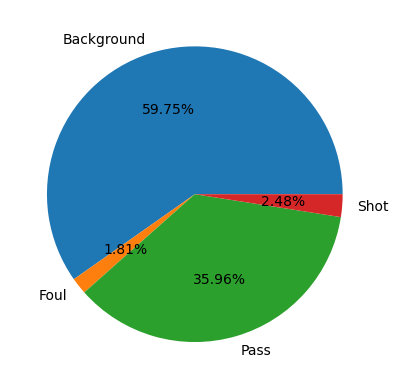

In [17]:
f = df.groupby(['class_coarse']).size().plot(kind='pie', y='class_coarse', autopct='%1.2f%%')


### Adding info to meta file

In [3]:
sql = 16
sr = 2
dataset_img = MultiModalHblDataset(
    meta_path="/nfs/home/rhotertj/datasets/hbl/meta3d.csv",
    seq_len=sql,
    sampling_rate=sr,
    load_frames=True   
)
# [(k, v) for (k,v) in dataset_img.event_dfs[0].head(20)["labels"].items()]
# 12126 O0
print("Match boundaries:", dataset_img.index_tracker)

Match boundaries: [0, 52591, 105630, 158361, 211599, 264342, 317543, 370311, 424395, 477834, 530423, 583398]


In [5]:
p = "/nfs/home/rhotertj/datasets/hbl/meta3d.csv"
df = pd.read_csv(p, index_col="match_id")

for stage in ["train", "val", "test"]:
    df[df.stage == stage].to_csv(f"/nfs/home/rhotertj/datasets/hbl/meta3d_{stage}.csv")

### Debugging idx -> Frame index mapping

In [ ]:
sql = 4
hql = sql // 2
rate = 2
sr = sql * rate
hr = hql * rate
kernel = np.ones(sr)

availables = [True, True, True, True, True, True, True, True, True, True, True, True, True, False, False]
pos = np.arange(len(availables))

cv = np.convolve(availables, kernel)
print(f"{cv}")
idxs = np.where(cv == sr)[0] - (sr - 1) # subtract filter length - 1
print("idx for valid sequences:", idxs)

q_idx = 0
f_idx = idxs[q_idx] + hr
sequence = pos[f_idx - hr : f_idx + hr : rate]
print(f"Idx for sequence {q_idx}: {sequence}")

### Visualizing each class

In [ ]:
sql = 16
sr = 2
dataset_img = MultiModalHblDataset(
    meta_path="/nfs/home/rhotertj/datasets/hbl/meta3d.csv",
    seq_len=sql,
    sampling_rate=sr,
    load_frames=True
)
# TODO: Take jsonl dataset instead class2frame
with open("class2frame.pkl", "rb") as f:
    class2frame = pkl.load(f)

In [ ]:
os.makedirs("../img/classes", exist_ok=True)
n_per_class = 3
for cls, frame_lists in class2frame.items():
    match_id = 0
    frame_id = 0
    n = 0
    for i, fl in enumerate(frame_lists):
        if n == n_per_class:
            break
        if fl:
            match_id = i
            try:
                frame_id = fl[(len(fl) // 2) + n] # dont take first pass of the game
            except:
                continue
            example = dataset_img.__getitem__(0, frame_idx=frame_id, match_number=match_id)
            frames = example["frames"].transpose(1, 0, 2, 3)
            gifname = f"../img/classes/{cls}_{n}_{match_id}x{frame_id}.gif"
            array2gif(frames, gifname, fps=10)

            positions = example["positions"]
            fig = draw_trajectory(positions)
            figname = f"../img/classes/{cls}_{n}_{match_id}x{frame_id}.png"
            fig.savefig(figname)
            print(figname)
            print(gifname)

            n+= 1
            

### Calculating Mean and Standard Deviation

In [ ]:
sql = 16
sr = 1
dataset_img = MultiModalHblDataset(
    meta_path="/nfs/home/rhotertj/datasets/hbl/meta3d.csv",
    seq_len=sql,
    sampling_rate=sr,
    load_frames=True
)
print(len(dataset_img))
n = 0
means = np.zeros((len(dataset_img) + sql, 3))
stds = np.zeros((len(dataset_img) + sql, 3))

for i in tqdm(range(0, len(dataset_img), sql)):
    frames = torch.tensor(dataset_img[i]["frames"]) / 255

    for j, frame in enumerate(frames):
        mean, std = frame.mean([1,2]), frame.std([1,2])
        means[i+j] = mean
        stds[i+j] = std

        n+=1
print(n)
print(means.shape)
# Maybe we want to calculate this per match instead of over the whole dataset


In [ ]:
np.save("means.npy", means)
np.save("std.npy", stds)

In [ ]:
print(means.mean(0), stds.mean(0))